In [75]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
import jieba
from collections import Counter

In [76]:
test_data = pd.read_excel('data/test.xlsx')
test_data['content'] = test_data['title'] + test_data['body']
test_data = test_data.drop(columns=['title','body'])
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.sort_values(by='date')
test_data['content'] = test_data['content'].apply(lambda x: ' '.join(x.split(', ')))
test_data

,date,content
0,1970-01-01 00:00:00.020240101,big thing industry positive changes exciting o...
1,1970-01-01 00:00:00.020240101,leadership layoff rumors future bleak measures...
2,1970-01-01 00:00:00.020240101,demographics results analyzed experts data imp...


In [77]:
# 训练 Word2Vec 模型
model = Word2Vec(sentences=test_data['content'], vector_size=50, window=5, min_count=1, workers=4)

# 定义一个函数，将文本转换为向量
def text_to_vector(text, model):
    vectors = []
    for word in text:
        if word in model.wv:
            vectors.append(model.wv[word])
    if not vectors:
        # 如果文本中没有有效的词向量，返回全零向量
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# 将每条新闻转换为向量
test_data['vector'] = test_data['content'].apply(lambda x: text_to_vector(x, model))
# 提取所有新闻的向量数据
X = np.array(test_data['vector'].tolist())

# 假设聚类数量为 2，可根据实际情况调整
num_clusters = 2

# 创建 KMeans 模型
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# 进行聚类
labels = kmeans.fit_predict(X)

# 将聚类标签添加到原数据中
test_data['cluster_label'] = labels
test_data


,date,content,vector,cluster_label
0,1970-01-01 00:00:00.020240101,big thing industry positive changes exciting o...,"[-0.0056836125, 0.0025028363, -0.0018142522, 0...",1
1,1970-01-01 00:00:00.020240101,leadership layoff rumors future bleak measures...,"[-0.004108141, -0.0004473182, -0.0019219912, 0...",0
2,1970-01-01 00:00:00.020240101,demographics results analyzed experts data imp...,"[-0.0042036553, -0.0010548412, -0.0006297452, ...",1


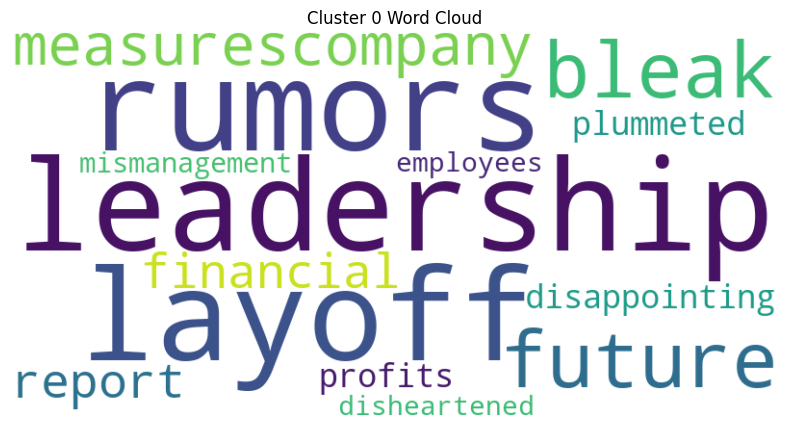

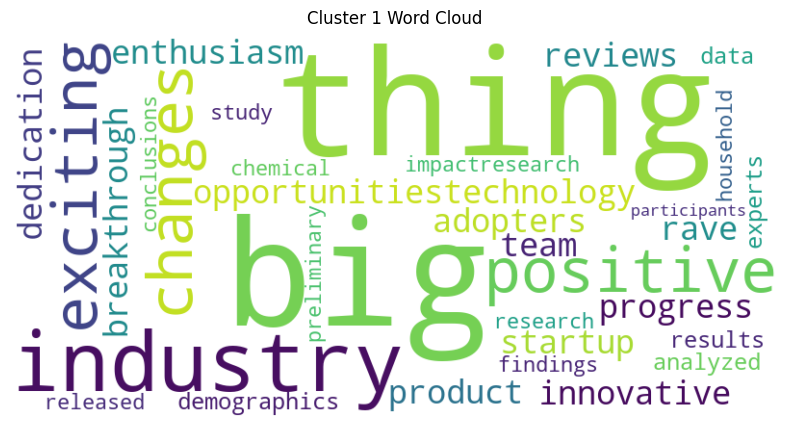

In [78]:
# 定义一个函数来生成词云
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# 获取每个聚类的高频词
for cluster in range(num_clusters):
    # 将属于同一聚类的文本合并为一个字符串
    cluster_text = ' '.join(test_data[test_data['cluster_label'] == cluster]['content'])
    plot_word_cloud(cluster_text, f'Cluster {cluster} Word Cloud')

In [79]:
# 评估聚类效果
if len(set(labels)) > 1:
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    print(f"轮廓系数: {silhouette}")
    print(f"Calinski - Harabasz 指数: {ch_score}")
else:
    print("由于簇的数量不大于 1，无法计算聚类评估指标。")


轮廓系数: -0.003391082165762782
Calinski - Harabasz 指数: 1.053508445105457


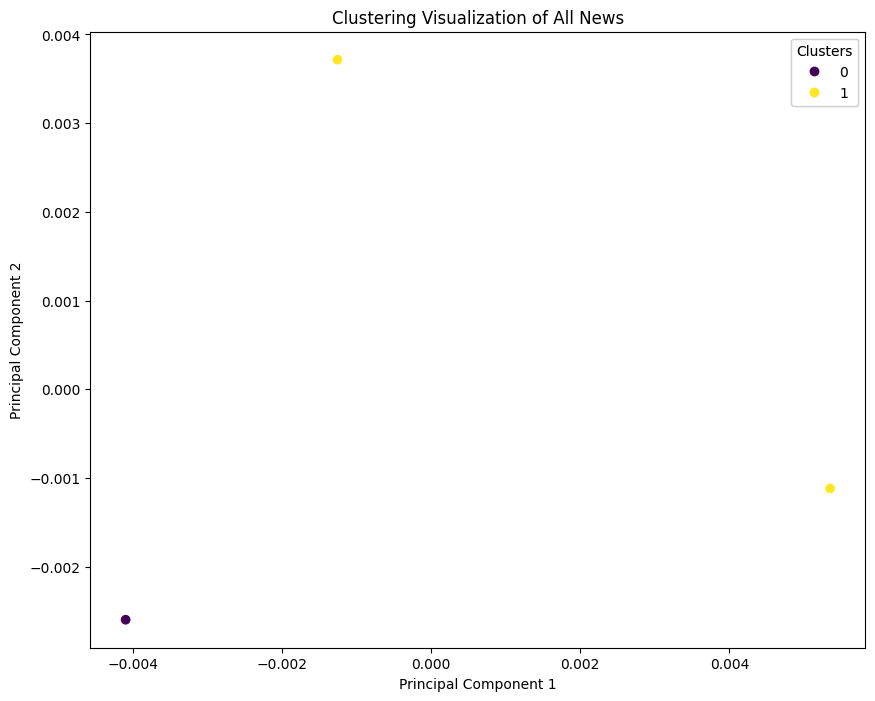

In [80]:
# 使用 PCA 将数据降到二维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 绘制散点图
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)
plt.title('Clustering Visualization of All News')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [81]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 将日期转换为日期类型
test_data['date'] = pd.to_datetime(test_data['date'])
# 按日期分组
grouped = test_data.groupby('date')

# 加载 DistilBERT 模型和分词器
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# 存储每天每个聚类的情感指数结果
sentiment_results = []

# 将模型移到 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []
        
        for content in cluster_data['content']:
            # 如果 content 是列表，将其转换为字符串
            if isinstance(content, list):
                text = " ".join(str(item) for item in content)
            else:
                text = str(content)
                
            try:
                # 编码文本，设置最大长度为 512
                inputs = tokenizer(text, return_tensors="pt", truncation=True, 
                                 padding=True, max_length=512)
                # 将输入移到相同的设备
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # 获取模型输出
                with torch.no_grad():
                    outputs = model(**inputs)
                
                # 处理预测结果
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=-1)
                
                # DistilBERT SST-2 的标签顺序：negative [0], positive [1]
                positive_prob = probabilities[0][1].item()
                negative_prob = probabilities[0][0].item()
                
                # 计算情感得分：积极概率 - 消极概率
                sentiment_score = positive_prob - negative_prob
                sentiment_scores.append(sentiment_score)
                
            except Exception as e:
                print(f"处理文本时出错: {text[:50]}...，错误信息: {e}")
                continue
        
        # 计算平均情感得分
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
        
        sentiment_results.append({
            'date': date,
            'cluster': cluster,
            'sentiment_score': average_sentiment,
            'num_samples': len(sentiment_scores)  # 添加样本数，便于检查
        })

# 创建 DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

# 打印结果
print(sentiment_df)

                           date  cluster  sentiment_score  num_samples
0 1970-01-01 00:00:00.020240101        0        -0.999307            1
1 1970-01-01 00:00:00.020240101        1         0.583981            2
